In [1]:
using CSV, GZip, DataFrames
using Makie
using Statistics

In [2]:
import Base.coalesce
coalesce(df::DataFrame, value) = DataFrame(colwise(c -> coalesce.(c, value), df), names(df))

normalize(a) = (a .- minimum(a)) ./ (maximum(a) - minimum(a))

normalize (generic function with 1 method)

In [3]:
cd("..")

In [4]:
results = GZip.open("data/behaviour/colors/" *
        "nnodes=1000-sharedl1=false-decadjdeep=true-" *
        "model=ov-correlation=0:0.1:1-spill=-9:9-dimxi=10:2:20-nsamples=20.csv.gz",
        "r") do io
    CSV.read(io)
end |> DataFrame;

In [5]:
results = by(results, [:nnodes, :sharedl1, :decadjdeep, :correlation, :spill, :dimξ, :sample],
    (:epoch, :adj, :feat, :kl, :reg, Symbol("total loss")) =>
    x -> (m = findmin(x[Symbol("total loss")])[2]; map(v -> v[m], x)));

In [6]:
results_avg = aggregate(results,
    [:nnodes, :sharedl1, :decadjdeep, :correlation, :spill, :dimξ],
    mean)

disallowmissing!(results_avg, [:nnodes, :sharedl1, :decadjdeep, :correlation, :spill, :dimξ])
allowmissing!(results_avg, [:sample_mean, :epoch_mean, :adj_mean, :feat_mean, :kl_mean, :reg_mean, Symbol("total loss_mean")])

for dimξ in unique(results_avg.dimξ)
    for correlation in unique(results_avg.correlation)
        for spill in unique(results_avg.spill)
            idx = (results_avg.dimξ .== dimξ) .& (results_avg.correlation .== correlation) .& (results_avg.spill .== spill)
            lines = results_avg[idx, :]
            if size(lines, 1) == 0
                push!(results_avg, (1000, false, true, correlation, spill, dimξ,
                        missing, missing, missing, missing, missing, missing, missing))
            else
                @assert size(lines, 1) == 1
            end
        end
    end
end;

In [7]:
function plot_loss(df, filters, loss, xname, yname)
    df = sort(df, (yname, xname))
    idx = trues(size(df, 1))
    for (field, value) in filters
        idx = idx .& (df[field] .== value)
    end
    
    fullloss = Symbol(loss * "_mean")
    x = Array{Float32}(unique(df[idx, xname]))
    y = Array{Float32}(unique(df[idx, yname]))
    z = reshape(Array{Float32}(df[idx, fullloss]), length(x), length(y))
    
    x = normalize(x)
    y = normalize(y)
    z = normalize(z)
    
    scene = surface(x, y, z, colormap = :Spectral)
    xm, ym, zm = minimum(scene.limits[])
    #wireframe!(scene, x, y, z .+ 0.05)
    contour!(scene, x, y, z, levels = 15, linewidth = 2, transformation = (:xy, zm))
    axis = scene[Axis]
    axis[:names, :axisnames] = (String(xname), String(yname), loss)
    scene
end

plot_loss (generic function with 1 method)

x = spill

y = correlation

z = best total mean

columns = overlap

┌ Warning: dropmissing will change eltype of cols to disallow missing by default. Use dropmissing(df, cols, disallowmissing=false) to allow for missing values.
│   caller = dropmissing(::DataFrame) at abstractdataframe.jl:643
└ @ DataFrames /home/sl/.julia/packages/DataFrames/IKMvt/src/abstractdataframe/abstractdataframe.jl:643


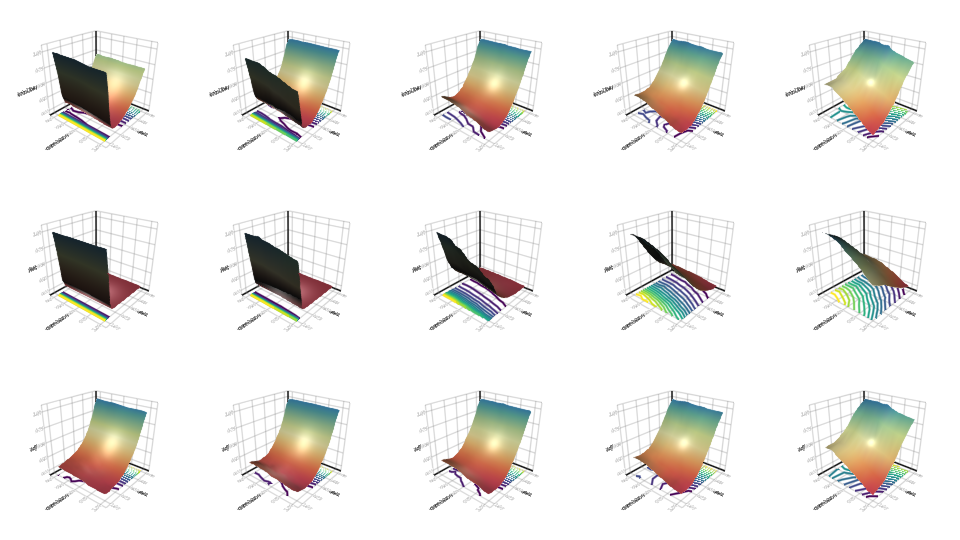

In [8]:
vbox(
    [hbox(
        [plot_loss(dropmissing(results_avg), [:dimξ => dimξ], loss, :spill, :correlation)
                for loss in ["adj", "feat", "total loss"]]...
    ) for dimξ = 20:-2:12]...)

x = spill

y = dim$\xi$

z = best total mean

columns = correlation

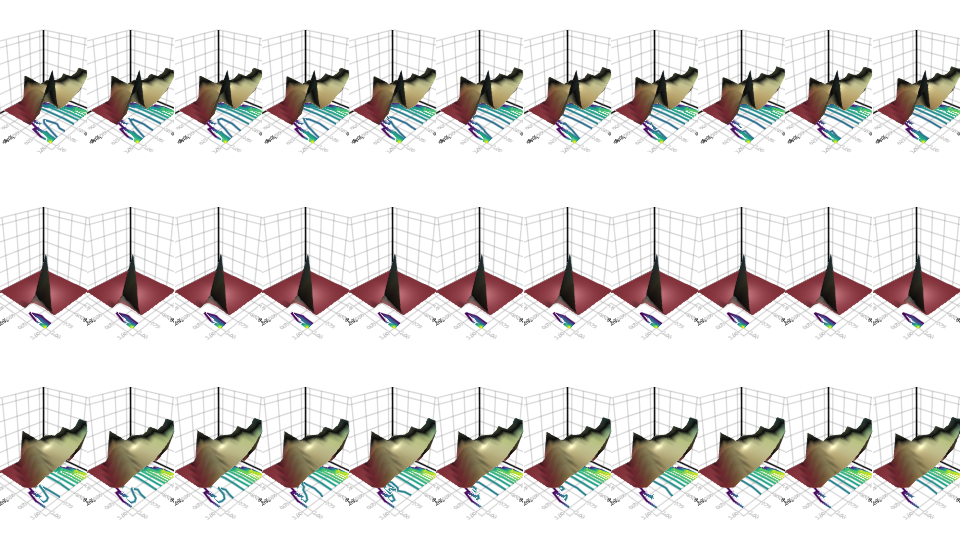

In [9]:
vbox(
    [hbox(
        [plot_loss(coalesce(results_avg, 0), [:correlation => correlation], loss, :spill, :dimξ)
                for loss in ["adj", "feat", "total loss"]]...
    ) for correlation = 0:0.1:1]...)